In [1]:
import numpy as np
import tensorflow as tf
import keras
import scipy.io
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import keras.backend as K

from matplotlib import pyplot as plt

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import AveragePooling1D,MaxPooling1D,UpSampling1D,AveragePooling2D,MaxPooling2D,UpSampling2D
from keras.models import Sequential
from keras.layers import Input,Conv1D,Conv2D,Conv2DTranspose,Reshape
from keras.layers import Activation,Dense,Dropout,BatchNormalization
from keras.layers import Flatten,Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from sklearn import preprocessing,metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix


Using TensorFlow backend.


In [2]:
pathAddress="C:\\Users\\HP\\Desktop\\KaunsiElectivesLenaHai\\Neural Network and fuzzy logic BITS F312"
arr=scipy.io.loadmat(pathAddress+"\\data_for_cnn.mat")
df=arr['ecg_in_window']
label=scipy.io.loadmat(pathAddress+"\\class_label.mat")
labels=label['label']


In [3]:
normal=preprocessing.StandardScaler()
df=normal.fit_transform(df)

X=np.expand_dims(df,axis=2)
Y=labels

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=1)

#print(x_train.shape,x_test.shape)#(800, 1000, 1) (200, 1000, 1)
#print("length of x_train :",len(x_train))# 800
#print("length of y_train :",len(y_train))# 800

#print(x_train)

#print(y_train.shape,y_test.shape)#(800,1) (200,1)
#print(y_train)
y_train=y_train.reshape(y_train.shape[0],y_train.shape[1],1)
y_test=y_test.reshape(y_test.shape[0],y_test.shape[1],1)
#print("length of x_train :",len(x_train))# 800
#print("length of y_train :",len(y_train))# 800
#print(y_train.shape,y_test.shape)#(800, 1, 1) (200, 1, 1)


In [4]:
import keras.backend as K

#def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
#    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
#    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
#    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
#    return x

In [5]:
def build_model(img_shape):
        input_layer = Input(shape=img_shape)
        
        # encoder
        h = Conv1D(50,1000,activation='relu',input_shape=(1000,1))(input_layer)
        h = MaxPooling1D(pool_size=1, padding='same')(h)
        #h = Flatten()(h)
        #h = Dropout(0.2)(h)
        
        # decoder
        h = Dense(100,activation='sigmoid')(h)
        h = Dropout(0.2)(h)
        h = UpSampling1D(size=1)(h)
        
        kernel_size=1
        filters=1
        strides=1
        padding='same'
        
        h = Lambda(lambda x: K.expand_dims(x, axis=2))(h)
        h = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(h)
        output_layer = Lambda(lambda x: K.squeeze(x, axis=2))(h)
        
       
        return Model(input_layer, output_layer)
    

In [6]:
img_rows = 800
img_cols = 1000
channels = 1
#img_shape = (img_rows, img_cols, channels)
img_shape = ( img_cols, channels)
        
optimizer = Adam(lr=0.001)
        
autoencoder_model = build_model(img_shape)
autoencoder_model.compile(loss='mse', optimizer=optimizer,metrics=['mean_squared_error','acc'])
autoencoder_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 50)             50050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 50)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 100)            5100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 1, 100)            0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 1, 100)         0   

In [7]:
def train_model(autoencoder_model,x_train, y_train, epochs, batch_size=20):
    history=[]
    early_stopping = EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=5,
                                verbose=1, 
                                mode='auto')
    
    
    history.append(autoencoder_model.fit(x_train,y_train ,
            epochs=epochs,
            callbacks=[early_stopping]))
    
    print(history[0].history.keys())
    
    plt.plot(history[0].history['loss'])
    
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    plt.figure()
    plt.plot(history[0].history['acc'])
    
    plt.title('Model Accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    

In [8]:
def eval_model(autoencoder_model,x_test):
    preds = autoencoder_model.predict(x_test)
    return preds
    

Epoch 1/300
800/800 [==============================] - 1s 642us/step - loss: 0.3763 - mean_squared_error: 0.3763 - acc: 0.5275
Epoch 2/300
800/800 [==============================] - 0s 133us/step - loss: 0.3551 - mean_squared_error: 0.3551 - acc: 0.5512
Epoch 3/300
288/800 [=========>....................] - ETA: 0s - loss: 0.3103 - mean_squared_error: 0.3103 - acc: 0.5938

C:\Users\HP\AppData\Roaming\Python\Python37\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


800/800 [==============================] - 0s 161us/step - loss: 0.3050 - mean_squared_error: 0.3050 - acc: 0.5850
Epoch 4/300
800/800 [==============================] - 0s 121us/step - loss: 0.3009 - mean_squared_error: 0.3009 - acc: 0.6112
Epoch 5/300
800/800 [==============================] - 0s 120us/step - loss: 0.2615 - mean_squared_error: 0.2615 - acc: 0.6625
Epoch 6/300
800/800 [==============================] - 0s 119us/step - loss: 0.2296 - mean_squared_error: 0.2296 - acc: 0.6812
Epoch 7/300
800/800 [==============================] - 0s 116us/step - loss: 0.1911 - mean_squared_error: 0.1911 - acc: 0.7237
Epoch 8/300
800/800 [==============================] - 0s 124us/step - loss: 0.1933 - mean_squared_error: 0.1933 - acc: 0.7412
Epoch 9/300
800/800 [==============================] - 0s 114us/step - loss: 0.1511 - mean_squared_error: 0.1511 - acc: 0.8000
Epoch 10/300
800/800 [==============================] - 0s 102us/step - loss: 0.1410 - mean_squared_error: 0.1410 - acc: 0.

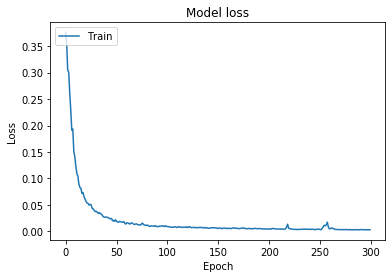

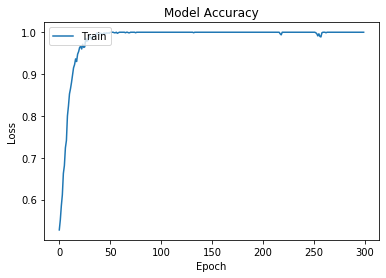

In [9]:
numEpochs=300
train_model(autoencoder_model,x_train,y_train,epochs=numEpochs,batch_size=20)


In [10]:
predictions=eval_model(autoencoder_model,x_test)
print("predictions =>",predictions.ravel())
print("y_test =>",y_test.ravel())

predictions => [ 1.04907846e+00  8.47971618e-01 -1.36626527e-01 -2.05323249e-02
  9.61106271e-02  1.02915645e+00 -2.48379514e-01  9.02010620e-01
 -6.35435730e-02  1.06752664e-02  9.52737570e-01  1.01258588e+00
  5.94216526e-01 -4.26058173e-02  8.15789461e-01  3.33873183e-02
  2.77330875e-01 -2.73034573e-01  9.84727621e-01  1.43073902e-01
  7.75110602e-01  2.29725510e-01  1.15857208e+00  4.58711922e-01
  9.59521055e-01 -2.11697966e-02  4.16784286e-02  9.27541971e-01
  1.07954693e+00 -2.37002969e-04  9.25771773e-01  8.81900430e-01
  5.22562116e-02  1.01889706e+00  3.51743519e-01 -7.22063929e-02
  1.53250039e-01  8.93365622e-01  9.02216434e-01  1.14968204e+00
  9.51241136e-01  1.09081841e+00  1.44211531e-01  3.20255786e-01
 -1.90481246e-02  8.65473807e-01  7.10518003e-01  8.40582848e-01
  6.86021566e-01  1.00215085e-01  1.05978109e-01  8.77248943e-01
  6.32520139e-01 -1.22536466e-01  1.74554557e-01  1.07980222e-02
  1.00210690e+00  9.10771489e-01  4.64332998e-01  9.65136647e-01
  8.583613

In [11]:
print(len(predictions.ravel()))
print(len(y_test.ravel()))

200
200


In [12]:
def convert_to_binary(pred_cls):
    for i in range(len(pred_cls)):
        if pred_cls[i]>=0.5:pred_cls[i]=1
        else:pred_cls[i]=0
    return pred_cls
pred_classes=convert_to_binary(predictions.ravel())

In [13]:
cm1 = confusion_matrix(y_test.ravel(),pred_classes)
print(cm1)

[[71 25]
 [12 92]]


In [14]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

print("For 2D confusion matrix")

tn, fp, fn, tp = cm1.ravel()
accuracy=(tp+tn)/(tp+tn+fp+fn)
accuracy*=100
recall=tp/(tp+fn)
recall*=100
precision=tp/(tp+fp)
precision*=100
f1_score=2*(recall*precision)/(recall+precision)

#print("accuracy : ",accuracy)
#print("recall : ",recall)
#print("precision : ",precision)
#print("f1_score : ",f1_score)

actual=y_test.ravel()
predicted=pred_classes
results = confusion_matrix(actual, predicted) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',100*accuracy_score(actual, predicted))  
print('Report : ')
print(classification_report(actual, predicted) )

For 2D confusion matrix
Confusion Matrix :
[[71 25]
 [12 92]]
Accuracy Score : 81.5
Report : 
              precision    recall  f1-score   support

           0       0.86      0.74      0.79        96
           1       0.79      0.88      0.83       104

    accuracy                           0.81       200
   macro avg       0.82      0.81      0.81       200
weighted avg       0.82      0.81      0.81       200

